# How To: Land-Use-Land-Cover Prediction for Lebanon

This notebook shows the steps towards constructing a machine learning pipeline for predicting the land use and land cover for Lebanon. We will use satellite images obtained by ESA's Sentinel-2 to train a model and use it for prediction. The example will lead you through the whole process of creating the pipeline, with details provided at each step.

## Before you start

### Requirements

In order to run the example you'll need a Sentinel Hub account. If you do not have one yet, you can create a free trial account at [Sentinel Hub webpage](https://www.sentinel-hub.com/trial). If you are a researcher you can even apply for a free non-commercial account at [ESA OSEO page](https://earth.esa.int/aos/OSEO).

Once you have the account set up, please configure the `sentinelhub` package's configuration file following the [configuration instructions](http://sentinelhub-py.readthedocs.io/en/latest/configure.html). For Processing API request you need to obtain and set your `oauth` client id and secret. 

### Overview

#### Part 1:

1. Define the Area-of-Interest (AOI):
   * Obtain the outline of Lebanon (provided)
   * Split into manageable smaller tiles
   * Select a small 5x5 area for classification
2. Use the integrated [sentinelhub-py](https://github.com/sentinel-hub/sentinelhub-py) package in order to fill the EOPatches with some content (band data, cloud masks, ...)
   * Define the time interval (this example uses the whole year of 2019)
3. Add additional information from band combinations (norm. vegetation index - NDVI, norm. water index - NDWI)
4. Add a reference map (provided)
   * Convert provided vector data to raster and add it to EOPatches
   
#### Part 2:

5. Prepare the training data
   * Remove too cloudy scenes
   * Perform temporal interpolation (filling gaps and resampling to the same dates)
   * Apply erosion 
   * Random spatial sampling of the EOPatches
   * Split patches for training/validation
6. Construct and train the ML model
   * Make the prediction for each patch 
7. Validate the model
8. Visualise the results

Let's start!

In [17]:
# Firstly, some necessary imports

# Jupyter notebook related
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import datetime
import itertools

# Built-in modules
import os

# Basics of Python data handling and visualization
import numpy as np
from aenum import MultiValueEnum

np.random.seed(42)
import geopandas as gpd
import joblib

# Machine learning
import lightgbm as lgb
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm, ListedColormap
from shapely.geometry import Polygon
from sklearn import metrics, preprocessing
from tqdm.auto import tqdm

from sentinelhub import DataCollection, UtmZoneSplitter

# Imports from eo-learn and sentinelhub-py
from eolearn.core import (
    EOExecutor,
    EOPatch,
    EOTask,
    EOWorkflow,
    FeatureType,
    LoadTask,
    MergeFeatureTask,
    OverwritePermission,
    SaveTask,
    linearly_connect_tasks,
)
from eolearn.features import NormalizedDifferenceIndexTask, SimpleFilterTask
from eolearn.features.extra.interpolation import LinearInterpolationTask
from eolearn.geometry import ErosionTask, VectorToRasterTask
from eolearn.io import ExportToTiffTask, SentinelHubInputTask, VectorImportTask
from eolearn.ml_tools import FractionSamplingTask

# Part 1

## 1. Define the Area-of-Interest (AOI):

* A geographical shape of Lebanon was taken from [Github](https://github.com/kamicut/lebanon-maps) and a buffer of 500 m was applied. The shape is available in repository: `lebanon_aoi.geojson`
* Convert it to selected CRS: taken to be the CRS of central UTM tile (UTM_33N)
* Split it into smaller, manageable, non-overlapping rectangular tiles
* Run classification on a selected 5x5 area

Be sure that your choice of CRS is the same as the CRS of your reference data.

In the case that you are having problems with empty data being downloaded, try changing the CRS to something that suits the location of the AOI better.

### Get country boundary

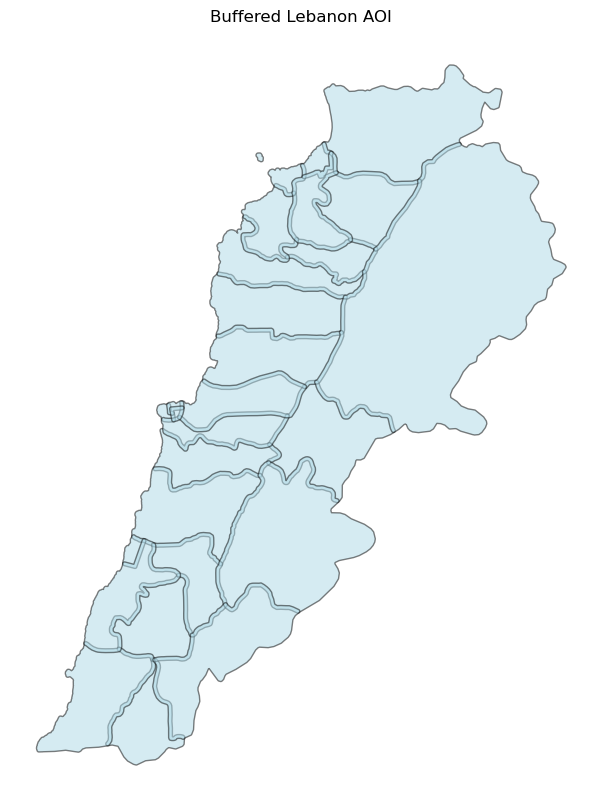

Buffered area dimensions: 20924 x 28372 meters


In [41]:
import os
import geopandas as gpd
import matplotlib.pyplot as plt

# Folder where data for running the notebook is stored
DATA_FOLDER = os.path.join(".", "example_data")

# Locations for collected data and intermediate results
EOPATCH_FOLDER = os.path.join(".", "eopatches")
EOPATCH_SAMPLES_FOLDER = os.path.join(".", "eopatches_sampled")
RESULTS_FOLDER = os.path.join(".", "results")

# Create necessary directories if they don't exist
for folder in (EOPATCH_FOLDER, EOPATCH_SAMPLES_FOLDER, RESULTS_FOLDER):
    os.makedirs(folder, exist_ok=True)

# Load geojson file
country = gpd.read_file(os.path.join(DATA_FOLDER, "lebanon_aoi.geojson"))

# Reproject to UTM Zone 36N (EPSG:32636) for accurate distance measurements
country = country.to_crs(epsg=32636)

# Add a 500m buffer to ensure sufficient data near the border
country['geometry'] = country.buffer(500)

# Plot the buffered country
fig, ax = plt.subplots(figsize=(10, 10))
country.plot(ax=ax, color="lightblue", edgecolor="black", alpha=0.5)
plt.title("Buffered Lebanon AOI")
plt.axis("off")
plt.show()

# Calculate dimensions of the buffered area
minx, miny, maxx, maxy = country.bounds.iloc[0]
country_width = maxx - minx
country_height = maxy - miny

# Print size of the buffered area
print(f"Buffered area dimensions: {country_width:.0f} x {country_height:.0f} meters")


### Split to smaller tiles and choose a 5x5 area

The splitting choice depends on the available resources of your computer. An EOPatch with a size of has around 500 x 500 pixels at 10 meter resolution has a size ob about ~1 GB.

Warning! Only 1 patches were selected, not enough for a 5x5 grid.


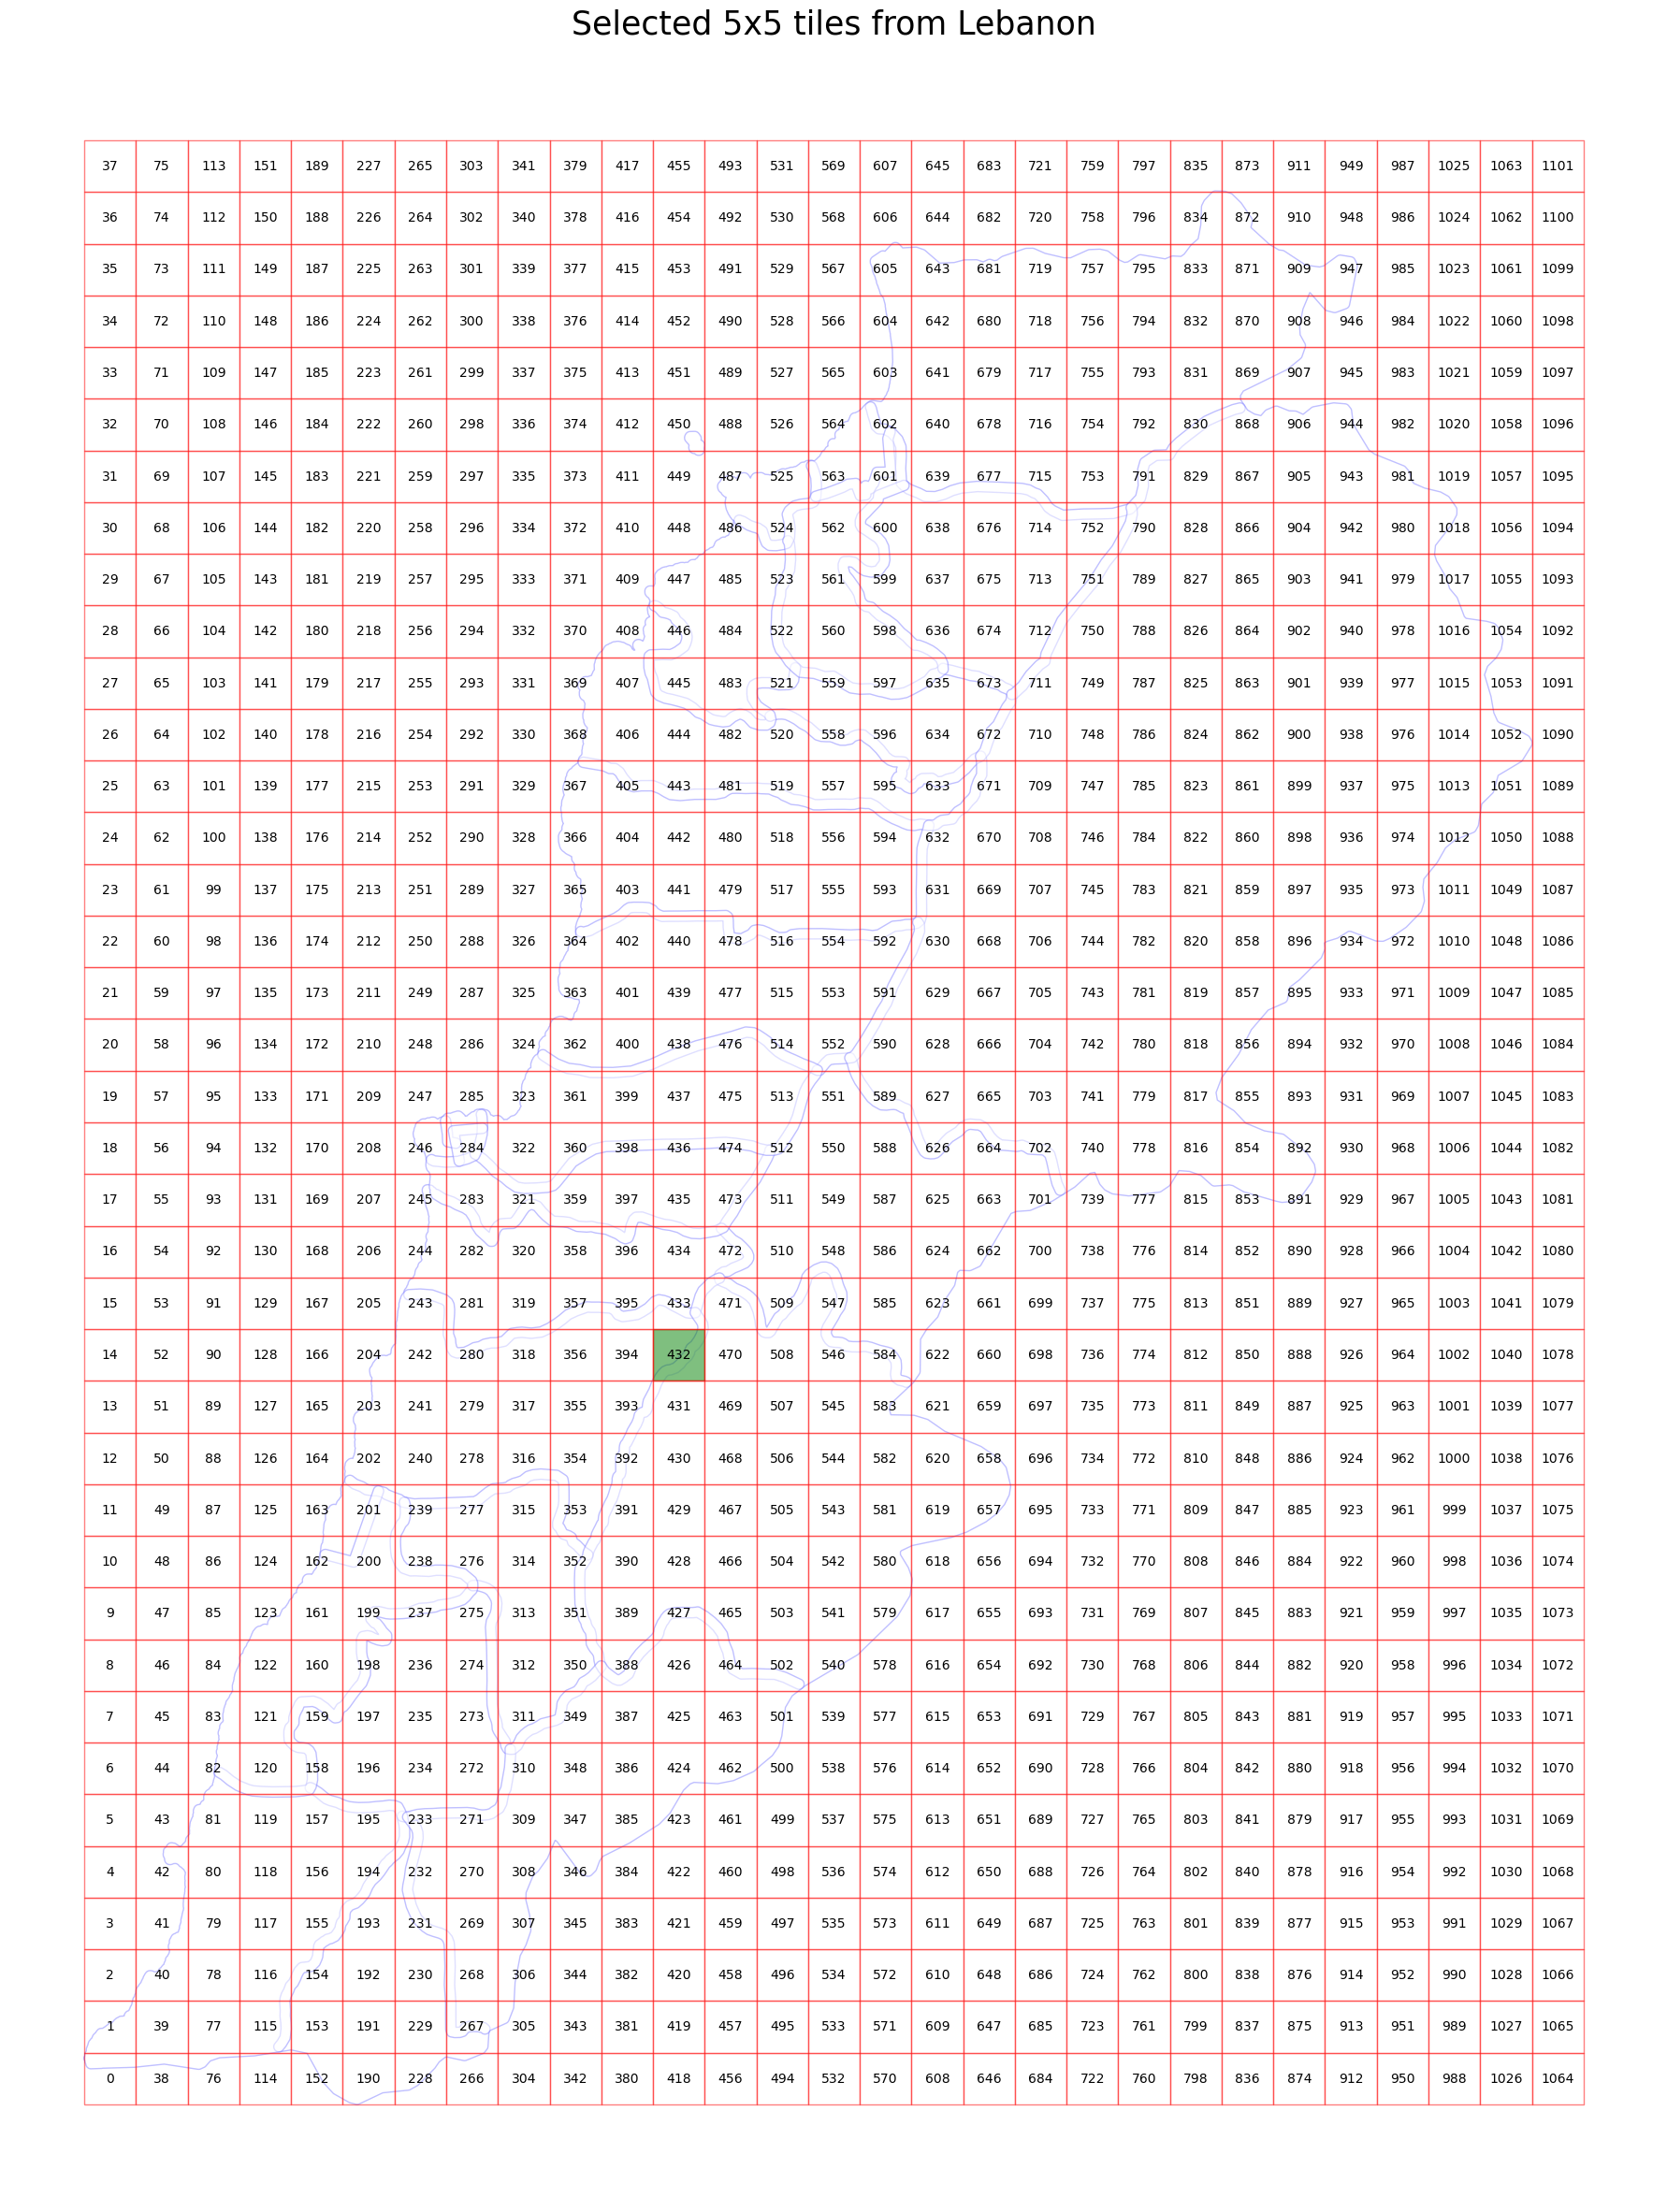

In [40]:
# Define the class for splitting the grid
class UtmZoneSplitter:
    def __init__(self, country_shapes, crs, grid_size):
        self.country_shapes = country_shapes
        self.crs = crs
        self.grid_size = grid_size  # in meters (5km for 5000m)

    def get_bbox_list(self):
        # Get bounds of the country area
        minx, miny, maxx, maxy = self.country_shapes.total_bounds  # Correct access to total_bounds
        # Create bounding boxes for the full extent of the country (Lebanon in this case)
        bboxes = []
        for x in np.arange(minx, maxx, self.grid_size):
            for y in np.arange(miny, maxy, self.grid_size):
                bboxes.append(Polygon([(x, y), (x + self.grid_size, y), (x + self.grid_size, y + self.grid_size), (x, y + self.grid_size)]))
        return bboxes

    def get_info_list(self):
        info_list = []
        for idx, bbox in enumerate(self.get_bbox_list()):
            minx, miny, maxx, maxy = bbox.bounds
            info = {"index": idx, "index_x": (minx + maxx) / 2, "index_y": (miny + maxy) / 2}
            info_list.append(info)
        return info_list


# Create a splitter to obtain a list of bboxes with 5km sides
bbox_splitter = UtmZoneSplitter(country.geometry, country.crs, 5000)

# Get the bounding boxes and their information
bbox_list = np.array(bbox_splitter.get_bbox_list())
info_list = np.array(bbox_splitter.get_info_list())

# Prepare info of selected EOPatches
geometry = [Polygon(bbox.exterior.coords) for bbox in bbox_list]
idxs = [info["index"] for info in info_list]
idxs_x = [info["index_x"] for info in info_list]
idxs_y = [info["index_y"] for info in info_list]

bbox_gdf = gpd.GeoDataFrame({"index": idxs, "index_x": idxs_x, "index_y": idxs_y}, crs=country.crs, geometry=geometry)

# Select a central patch ID (must be adjusted based on the number of patches)
ID = 432

# Obtain surrounding 5x5 patches
patch_ids = []
for idx, info in enumerate(info_list):
    if abs(info["index_x"] - info_list[ID]["index_x"]) <= 2 and abs(info["index_y"] - info_list[ID]["index_y"]) <= 2:
        patch_ids.append(idx)

# Check if the final size is 5x5
if len(patch_ids) != 5 * 5:
    print("Warning! Only", len(patch_ids), "patches were selected, not enough for a 5x5 grid.")

# Save the bounding boxes to a shapefile
shapefile_name = "grid_lebanon_5000x5000.gpkg"
bbox_gdf.to_file(os.path.join(RESULTS_FOLDER, shapefile_name), driver="GPKG")

# Plot the bboxes over the country
fig, ax = plt.subplots(figsize=(30, 30))
ax.set_title("Selected 5x5 tiles from Lebanon", fontsize=25)
country.plot(ax=ax, facecolor="w", edgecolor="b", alpha=0.5)
bbox_gdf.plot(ax=ax, facecolor="w", edgecolor="r", alpha=0.5)

for bbox, info in zip(bbox_list, info_list):
    geo = bbox
    ax.text(geo.centroid.x, geo.centroid.y, info["index"], ha="center", va="center")

# Mark bboxes of selected area
bbox_gdf[bbox_gdf.index.isin(patch_ids)].plot(ax=ax, facecolor="g", edgecolor="r", alpha=0.5)

plt.axis("off")
plt.show()

In [20]:
class SentinelHubValidDataTask(EOTask):
    """
    Combine Sen2Cor's classification map with `IS_DATA` to define a `VALID_DATA_SH` mask
    The SentinelHub's cloud mask is asumed to be found in eopatch.mask['CLM']
    """

    def __init__(self, output_feature):
        self.output_feature = output_feature

    def execute(self, eopatch):
        eopatch[self.output_feature] = eopatch.mask["IS_DATA"].astype(bool) & (~eopatch.mask["CLM"].astype(bool))
        return eopatch


class AddValidCountTask(EOTask):
    """
    The task counts number of valid observations in time-series and stores the results in the timeless mask.
    """

    def __init__(self, count_what, feature_name):
        self.what = count_what
        self.name = feature_name

    def execute(self, eopatch):
        eopatch[FeatureType.MASK_TIMELESS, self.name] = np.count_nonzero(eopatch.mask[self.what], axis=0)
        return eopatch

In [21]:

# BAND DATA
# Add a request for S2 bands.
# Here we also do a simple filter of cloudy scenes (on tile level).
# The s2cloudless masks and probabilities are requested via additional data.
band_names = ["B02", "B03", "B04", "B08", "B11", "B12"]
add_data = SentinelHubInputTask(
    bands_feature=(FeatureType.DATA, "BANDS"),
    bands=band_names,
    resolution=10,
    maxcc=0.8,
    time_difference=datetime.timedelta(minutes=120),
    data_collection=DataCollection.SENTINEL2_L1C,
    additional_data=[(FeatureType.MASK, "dataMask", "IS_DATA"), (FeatureType.MASK, "CLM"), (FeatureType.DATA, "CLP")],
    max_threads=5,
)


# CALCULATING NEW FEATURES
# NDVI: (B08 - B04)/(B08 + B04)
# NDWI: (B03 - B08)/(B03 + B08)
# NDBI: (B11 - B08)/(B11 + B08)
ndvi = NormalizedDifferenceIndexTask(
    (FeatureType.DATA, "BANDS"), (FeatureType.DATA, "NDVI"), [band_names.index("B08"), band_names.index("B04")]
)
ndwi = NormalizedDifferenceIndexTask(
    (FeatureType.DATA, "BANDS"), (FeatureType.DATA, "NDWI"), [band_names.index("B03"), band_names.index("B08")]
)
ndbi = NormalizedDifferenceIndexTask(
    (FeatureType.DATA, "BANDS"), (FeatureType.DATA, "NDBI"), [band_names.index("B11"), band_names.index("B08")]
)


# VALIDITY MASK
# Validate pixels using SentinelHub's cloud detection mask and region of acquisition
add_sh_validmask = SentinelHubValidDataTask((FeatureType.MASK, "IS_VALID"))

# COUNTING VALID PIXELS
# Count the number of valid observations per pixel using valid data mask
add_valid_count = AddValidCountTask("IS_VALID", "VALID_COUNT")



In [22]:
class LULC(MultiValueEnum):
    """Enum class containing basic LULC types"""

    NO_DATA = "No Data", 0, "#ffffff"
    CULTIVATED_LAND = "Cultivated Land", 1, "#ffff00"
    FOREST = "Forest", 2, "#054907"
    GRASSLAND = "Grassland", 3, "#ffa500"
    SHRUBLAND = "Shrubland", 4, "#806000"
    WATER = "Water", 5, "#069af3"
    WETLAND = "Wetlands", 6, "#95d0fc"
    TUNDRA = "Tundra", 7, "#967bb6"
    ARTIFICIAL_SURFACE = "Artificial Surface", 8, "#dc143c"
    BARELAND = "Bareland", 9, "#a6a6a6"
    SNOW_AND_ICE = "Snow and Ice", 10, "#000000"

    @property
    def id(self):
        return self.values[1]

    @property
    def color(self):
        return self.values[2]


# Reference colormap things
lulc_cmap = ListedColormap([x.color for x in LULC], name="lulc_cmap")
lulc_norm = BoundaryNorm([x - 0.5 for x in range(len(LULC) + 1)], lulc_cmap.N)


In [23]:
import os

# Get the current working directory (which is where the Jupyter notebook is)
base_dir = os.getcwd()  # This will be the directory where the notebook is located

# Define the relative path to the shapefile (since it's in the same directory)
shp_file = 'lebanon-latest-free'

# Combine the directory with the shapefile name to get the full path
land_use_ref_path = os.path.join(base_dir, shp_file)

# Print the absolute path for debugging
print("Full path to the file:", os.path.abspath(land_use_ref_path))

# Check if the file exists
if os.path.exists(land_use_ref_path):
    print("The file exists!")
else:
    print("The file does not exist.")



Full path to the file: C:\Users\moham\GeoAIProject\Final\Lebanon_LandCover_TimeSeries\Sentinel_Hub_LandCover\lebanon-latest-free
The file does not exist.


In [24]:
import fiona

# Attempt to read the shapefile using fiona directly
try:
    with fiona.open(land_use_ref_path) as src:
        print(f"CRS: {src.crs}")
        print(f"Bounds: {src.bounds}")
        print(f"Schema: {src.schema}")
except Exception as e:
    print(f"Error opening shapefile with Fiona: {e}")


Error opening shapefile with Fiona: Failed to open dataset (flags=68): C:\Users\moham\GeoAIProject\Final\Lebanon_LandCover_TimeSeries\Sentinel_Hub_LandCover\lebanon-latest-free


In [25]:
# LOAD EXISTING EOPATCHES
eopatches="eopatches"
eopatches_sampled="eopatches_sampled"
load = LoadTask(eopatches)

# FEATURE CONCATENATION
concatenate = MergeFeatureTask({FeatureType.DATA: ["BANDS", "NDVI", "NDWI", "NDBI"]}, (FeatureType.DATA, "FEATURES"))

# FILTER OUT CLOUDY SCENES (Custom Predicate Function)
def valid_data_filter(eopatch, threshold=0.8):
    """Filter out cloudy scenes by checking valid pixel fraction."""
    mask = eopatch.mask['IS_VALID']
    valid_fraction = np.mean(mask, axis=(1, 2, 3))  # Compute fraction of valid pixels per frame
    return valid_fraction > threshold  # Keep frames with >80% valid pixels

filter_task = SimpleFilterTask((FeatureType.MASK, "IS_VALID"), valid_data_filter)


# LINEAR TEMPORAL INTERPOLATION
# linear interpolation of full time-series and date resampling
resampled_range = ("2019-01-01", "2019-12-31", 15)
linear_interp = LinearInterpolationTask(
    (FeatureType.DATA, "FEATURES"),  # name of field to interpolate
    mask_feature=(FeatureType.MASK, "IS_VALID"),  # mask to be used in interpolation
    copy_features=[(FeatureType.MASK_TIMELESS, "LULC")],  # features to keep
    resample_range=resampled_range,
)

# EROSION
# erode each class of the reference map
erosion = ErosionTask(mask_feature=(FeatureType.MASK_TIMELESS, "LULC", "LULC_ERODED"), disk_radius=1)

# SPATIAL SAMPLING
# Uniformly sample pixels from patches
lulc_type_ids = [lulc_type.id for lulc_type in LULC]

spatial_sampling = FractionSamplingTask(
    features_to_sample=[(FeatureType.DATA, "FEATURES", "FEATURES_SAMPLED"), (FeatureType.MASK_TIMELESS, "LULC_ERODED")],
    sampling_feature=(FeatureType.MASK_TIMELESS, "LULC_ERODED"),
    fraction=0.25,  # a quarter of points
    exclude_values=[0],
)

save = SaveTask(eopatches_sampled, overwrite_permission=OverwritePermission.OVERWRITE_FEATURES)

In [26]:
# Define the workflow
workflow_nodes = linearly_connect_tasks(load, concatenate, filter_task, linear_interp, erosion, spatial_sampling, save)
workflow = EOWorkflow(workflow_nodes)

In [27]:
from sentinelhub import SHConfig

config = SHConfig()
config.sh_client_id = "8a79b09d-18b0-486d-b6ea-d788cd00ccae"
config.sh_client_secret = "b2OpVtLQhO4eyno7bhP3sjHG9jiSXaf4"
config.instance_id = "f3e0f33f-4c32-419a-89fc-4f6b5f334bde"
config.save()  # Save configuration for future use

print("Sentinel Hub authentication configured successfully!")

Sentinel Hub authentication configured successfully!


In [28]:
import os

# Define patch IDs (adjust as needed)
patch_ids = list(range(10))

# Ensure that each expected eopatch folder exists (create if missing)
for idx in patch_ids:
    folder = f"eopatches/eopatch_{idx}"
    if not os.path.exists(folder):
        print(f"Warning: Folder {folder} does not exist. Creating folder.")
        os.makedirs(folder, exist_ok=True)

if __name__ == "__main__":
    # Prepare execution arguments for each patch
    execution_args = []
    for idx in patch_ids:
        execution_args.append(
            {
                workflow_nodes[0]: {"eopatch_folder": f"eopatch_{idx}"},  # Load task configuration
                workflow_nodes[-2]: {"seed": 42},                           # Sampling task configuration
                workflow_nodes[-1]: {"eopatch_folder": f"eopatch_{idx}"},     # Save task configuration
            }
        )
    
    try:
        # Initialize the EOExecutor with the workflow and execution arguments
        executor = EOExecutor(workflow, execution_args, save_logs=True)
        
        # Run the workflow with a reduced number of workers to reduce memory pressure
        executor.run(workers=1)  # Adjust the worker count if needed
        
        # Generate the execution report
        executor.make_report()
        
        # Check for any failed executions and raise an error if found
        failed_ids = executor.get_failed_executions()
        if failed_ids:
            raise RuntimeError(
                f"Execution failed for EOPatches with IDs:\n{failed_ids}\n"
                f"See the report at {executor.get_report_path()} for more details."
            )
    except Exception as e:
        print("An error occurred during EOExecutor execution:")
        print(e)


  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\moham\anaconda3\Lib\site-packages\eolearn\core\eodata.py:374: EODeprecationWarning: Initializing an EOPatch without providing a BBox will no longer be possible in the future. EOPatches represent geolocated data and so any EOPatch without a BBox is ill-formed. Consider using a different data structure for non-geolocated data.
  super().__setattr__(key, value)
C:\Users\moham\anaconda3\Lib\site-packages\eolearn\core\eodata.py:374: EODeprecationWarning: Initializing an EOPatch without providing a BBox will no longer be possible in the future. EOPatches represent geolocated data and so any EOPatch without a BBox is ill-formed. Consider using a different data structure for non-geolocated data.
  super().__setattr__(key, value)
C:\Users\moham\anaconda3\Lib\site-packages\eolearn\core\eodata.py:374: EODeprecationWarning: Initializing an EOPatch without providing a BBox will no longer be possible in the future. EOPatches represent geolocated data and so any EOPatch without a BBox is ill

An error occurred during EOExecutor execution:
Execution failed for EOPatches with IDs:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
See the report at C:\Users\moham\GeoAIProject\Final\Lebanon_LandCover_TimeSeries\Sentinel_Hub_LandCover\eoexecution-report-2025_04_02-21_29_49\report.html for more details.


In [29]:
# Load sampled eopatches
sampled_eopatches = []

for i in range(len(patch_ids)):
    sample_path = os.path.join(eopatches_sampled, f"eopatches/eopatch_{i}")
    sampled_eopatches.append(EOPatch.load(sample_path, lazy_loading=True))

CreateFailed: root path 'C:\Users\moham\GeoAIProject\Final\Lebanon_LandCover_TimeSeries\Sentinel_Hub_LandCover\eopatches_sampled\eopatches\eopatch_0' does not exist

In [ ]:
import numpy as np

# Check total number of patches
num_patches = len(sampled_eopatches)
print("Number of sampled_eopatches:", num_patches)

# Define desired test indices (ensure they are in range)
test_ids = [0, 8, 16, 19, 20]
valid_test_ids = [i for i in test_ids if i < num_patches]
if len(valid_test_ids) < len(test_ids):
    print("Warning: Some test IDs were out of range and have been excluded.")

# Create test and train eopatch lists based on valid indices
test_eopatches = [sampled_eopatches[i] for i in valid_test_ids]
all_ids = list(range(num_patches))
train_ids = [i for i in all_ids if i not in valid_test_ids]
train_eopatches = [sampled_eopatches[i] for i in train_ids]

# Define the required keys for each eopatch
required_data_keys = ["FEATURES_SAMPLED"]
required_mask_keys = ["LULC_ERODED"]

def filter_valid_eopatches(eopatches):
    valid = []
    for idx, eopatch in enumerate(eopatches):
        missing_keys = []
        for key in required_data_keys:
            if key not in eopatch.data:
                missing_keys.append(f"data['{key}']")
        for key in required_mask_keys:
            if key not in eopatch.mask_timeless:
                missing_keys.append(f"mask_timeless['{key}']")
        if missing_keys:
            print(f"Warning: EOPatch at index {idx} is missing keys: {missing_keys}. Skipping this patch.")
        else:
            valid.append(eopatch)
    return valid

# Filter eopatches for train and test sets
train_eopatches = filter_valid_eopatches(train_eopatches)
test_eopatches = filter_valid_eopatches(test_eopatches)

# Ensure there are enough patches after filtering
if not train_eopatches or not test_eopatches:
    raise ValueError("Not enough valid eopatches to proceed after filtering for required keys.")

# Concatenate features and labels from the valid eopatches
features_train = np.concatenate(
    [eopatch.data["FEATURES_SAMPLED"] for eopatch in train_eopatches],
    axis=1
)
labels_train = np.concatenate(
    [eopatch.mask_timeless["LULC_ERODED"] for eopatch in train_eopatches],
    axis=0
)

features_test = np.concatenate(
    [eopatch.data["FEATURES_SAMPLED"] for eopatch in test_eopatches],
    axis=1
)
labels_test = np.concatenate(
    [eopatch.mask_timeless["LULC_ERODED"] for eopatch in test_eopatches],
    axis=0
)

# Get shape information (assuming features are 4D arrays: time, width, height, features)
t, w1, h, f = features_train.shape
t, w2, h, f = features_test.shape

# Reshape the features into 2D arrays: (width * height) x (time * features)
features_train = np.moveaxis(features_train, 0, 2).reshape(w1 * h, t * f)
labels_train = labels_train.reshape(w1 * h)

features_test = np.moveaxis(features_test, 0, 2).reshape(w2 * h, t * f)
labels_test = labels_test.reshape(w2 * h)

print("Features and labels prepared successfully.")


In [ ]:
for idx, eopatch in enumerate(sampled_eopatches):
    print(f"EOPatch {idx} data keys:", list(eopatch.data.keys()))
    print(f"EOPatch {idx} mask_timeless keys:", list(eopatch.mask_timeless.keys()))
